**Installing the required libraries**

In [ ]:
!pip install seedir
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the required libraries**

In [ ]:
import tarfile
import seedir as sd
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
from IPython.display import Audio
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import Input, Dense, Activation, Dropout, LSTM, GlobalAveragePooling1D, BatchNormalization
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.initializers import he_normal
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

**Extracting all the files from the tar file**

In [ ]:
# Downloading the data from the source
!wget https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/tensorflow-speech-commands.tar.gz

--2024-05-07 19:12:42--  https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/tensorflow-speech-commands.tar.gz
Resolving dax-cdn.cdn.appdomain.cloud (dax-cdn.cdn.appdomain.cloud)... 23.196.192.12, 2600:1409:8800:382::d2d, 2600:1409:8800:397::d2d
Connecting to dax-cdn.cdn.appdomain.cloud (dax-cdn.cdn.appdomain.cloud)|23.196.192.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1487676975 (1.4G) [application/x-gzip]
Saving to: ‘tensorflow-speech-commands.tar.gz’

tensorflow-speech-c 100%[===================>]   1.38G  2.62MB/s    in 7m 13s  

2024-05-07 19:19:57 (3.27 MB/s) - ‘tensorflow-speech-commands.tar.gz’ saved [1487676975/1487676975]



In [ ]:
# Extracting all the files from the tar file
with tarfile.open('tensorflow-speech-commands.tar.gz', 'r') as tar:
  tar.extractall()

In [ ]:
# Tree diagram of the directory
sd.seedir('TensorFlow-Speech-Commands', style='emoji',depthlimit=1,
          regex=True,
          exclude_files=['LICENSE','README.md','.*\.txt$'],
          beyond='content')

📁 TensorFlow-Speech-Commands/
├─📁 wow/
│ └─📄 0 folder(s), 1745 file(s)
├─📁 dog/
│ └─📄 0 folder(s), 1746 file(s)
├─📁 bird/
│ └─📄 0 folder(s), 1731 file(s)
├─📁 one/
│ └─📄 0 folder(s), 2370 file(s)
├─📁 six/
│ └─📄 0 folder(s), 2369 file(s)
├─📁 nine/
│ └─📄 0 folder(s), 2364 file(s)
├─📁 right/
│ └─📄 0 folder(s), 2367 file(s)
├─📁 sheila/
│ └─📄 0 folder(s), 1734 file(s)
├─📁 seven/
│ └─📄 0 folder(s), 2377 file(s)
├─📁 four/
│ └─📄 0 folder(s), 2372 file(s)
├─📁 down/
│ └─📄 0 folder(s), 2359 file(s)
├─📁 no/
│ └─📄 0 folder(s), 2375 file(s)
├─📁 yes/
│ └─📄 0 folder(s), 2377 file(s)
├─📁 go/
│ └─📄 0 folder(s), 2372 file(s)
├─📁 up/
│ └─📄 0 folder(s), 2375 file(s)
├─📁 bed/
│ └─📄 0 folder(s), 1713 file(s)
├─📁 zero/
│ └─📄 0 folder(s), 2376 file(s)
├─📁 on/
│ └─📄 0 folder(s), 2367 file(s)
├─📁 five/
│ └─📄 0 folder(s), 2357 file(s)
├─📁 happy/
│ └─📄 0 folder(s), 1742 file(s)
├─📁 stop/
│ └─📄 0 folder(s), 2380 file(s)
├─📁 eight/
│ └─📄 0 folder(s), 2352 file(s)
├─📁 left/
│ └─📄 0 folder(s), 2353 file(s)
├─📁 tree/
│ 

This tree diagram gives the pictorial representation of all the labels in the dataset and the corresponding number of files for each label.

In [ ]:
# Extracting all the audio paths and labels 
# from the TensorFlow-Speech-Commands directory
audio_path = []
labels     = []
for root, dirs, files in os.walk('TensorFlow-Speech-Commands'):
  for file in sorted(files):
    file_path = os.path.join(root, file)
    if 'wav' in file_path:
      audio_path.append(file_path)
      labels.append(file_path.split('/')[-2])

In [ ]:
# Creating a dataframe out of audio paths and labels lists
data = pd.DataFrame(list(zip(audio_path,labels)),columns=['audio_path','label'])
# Displaying the first 5 rows of the dataframe.
data.head()

,audio_path,label
0,TensorFlow-Speech-Commands/wow/004ae714_nohash...,wow
1,TensorFlow-Speech-Commands/wow/00f0204f_nohash...,wow
2,TensorFlow-Speech-Commands/wow/00f0204f_nohash...,wow
3,TensorFlow-Speech-Commands/wow/0132a06d_nohash...,wow
4,TensorFlow-Speech-Commands/wow/0135f3f2_nohash...,wow


In [ ]:
data.shape

(64727, 2)

There are 64727 files in the dataset

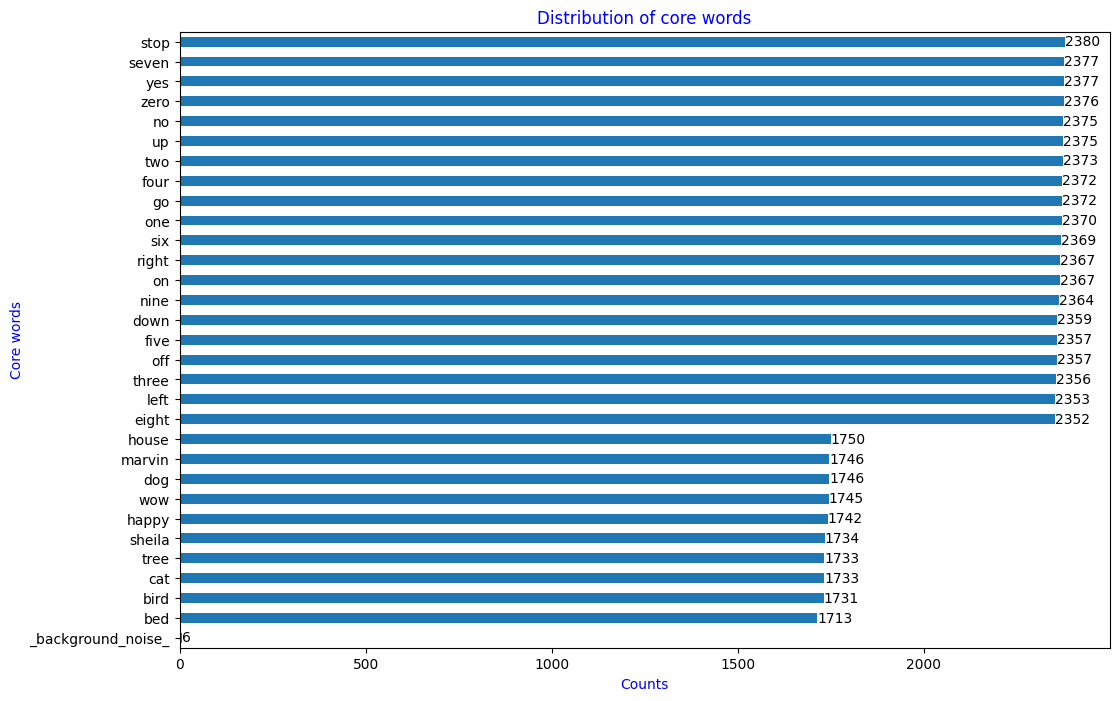

In [ ]:
plt.figure(figsize=(12,8))
ax = data.label.value_counts().sort_values().plot(kind = 'barh')

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Counts',color='blue')
plt.ylabel('Core words',color='blue')
plt.title('Distribution of core words',color='blue')
plt.show()

**Key findings:**<br>
- It can be observed that the number of audio files for the 'background noise' is as low as 6 files whereas the core word 'stop'  has 2380 audio files which is the highest among the dataset.


In [ ]:
# Dropping records with label "_background_noise_" since it has low counts and its a noise
data_removing_lowcounts = data[data['label'] != '_background_noise_']
data_removing_lowcounts.reset_index(drop=True, inplace=True)

In [ ]:
# Considering 70% of the data from the original data
data_sample,_ = train_test_split(data_removing_lowcounts,test_size=0.30, random_state=45,
                                 stratify=data_removing_lowcounts['label'])

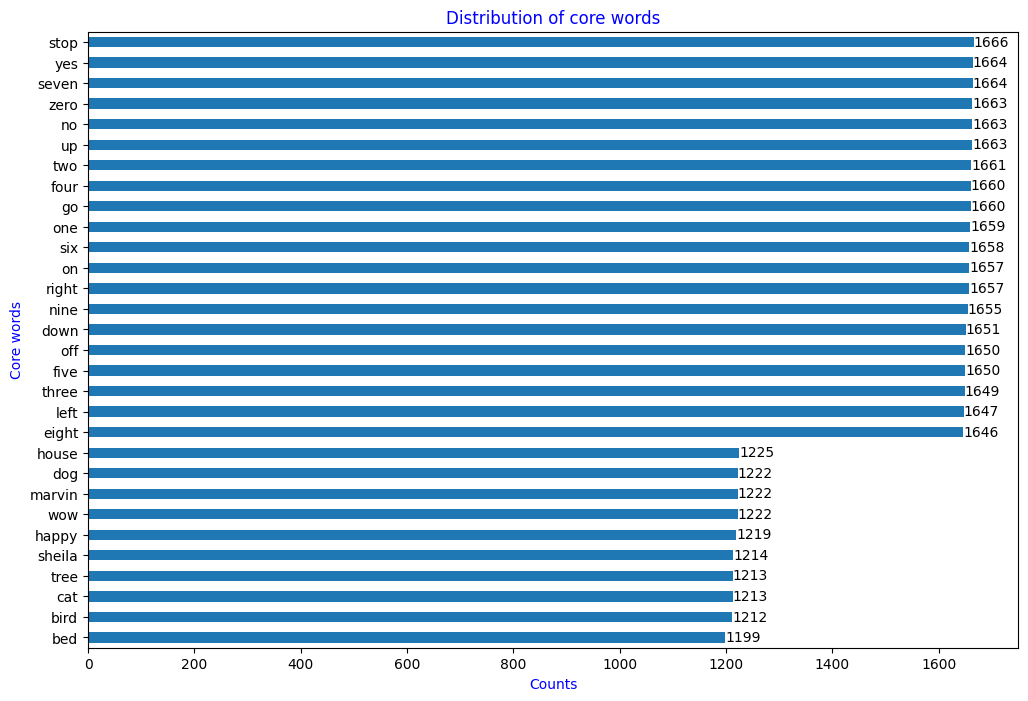

In [ ]:
# Checking the distribution of the data after sampling 70% of data from original data.

plt.figure(figsize=(12,8))
ax = data_sample.label.value_counts().sort_values().plot(kind = 'barh')

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Counts',color='blue')
plt.ylabel('Core words',color='blue')
plt.title('Distribution of core words',color='blue')
plt.show()

In [ ]:
# This function takes audio path as input and plots
# Spectrum of an audio file and plays the audio file

def plotting_spectrum(audio_path):
  # Reading the wave file
  sample_rate, sample_data = wavfile.read(audio_path)

  # Plotting spectrum of audio file
  n = len(sample_data)
  frequencies = np.fft.rfftfreq(n, d=1/sample_rate)
  spectrum = np.fft.rfft(sample_data)
  plt.figure(figsize=(10,4))
  plt.plot(frequencies, np.abs(spectrum))
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.title('Spectrum of Audio File')
  plt.show()
  print('\n')

  # Playing the audio file
  display(Audio(sample_data, rate=sample_rate))
  return None

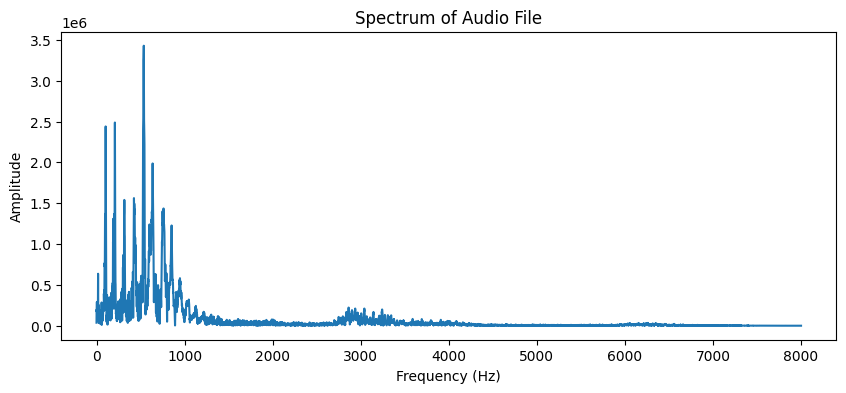

In [ ]:
# Taking a sample audio file with 'one' label and applying the plotting_spectrum
# function 
sample_1_file  = data_sample[data_sample['label']=='one']['audio_path'].tolist()[0]
plotting_spectrum(sample_1_file)

This audio file sounds one

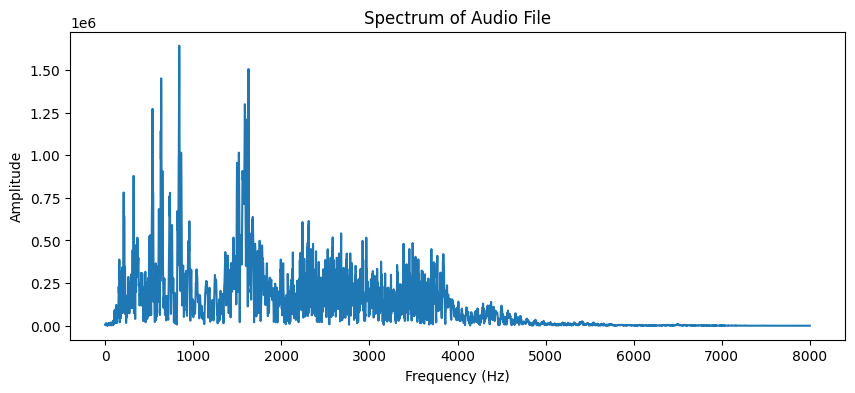

In [ ]:
# Taking a sample audio file with 'happy' label and applying the plotting_spectrum
# function 
sample_2_file  = data_sample[data_sample['label']=='happy']['audio_path'].tolist()[0]
plotting_spectrum(sample_2_file)

This audio file sounds happy

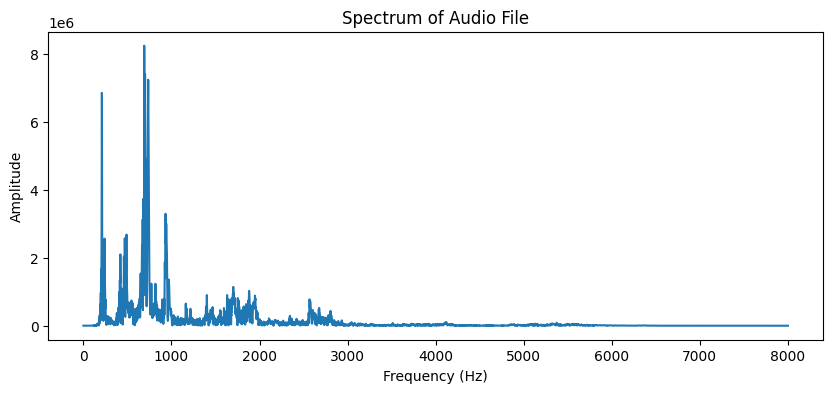

In [ ]:
# Taking a sample audio file with 'seven' label and applying the plotting_spectrum
# function 
sample_3_file  = data_sample[data_sample['label']=='seven']['audio_path'].tolist()[0]
plotting_spectrum(sample_3_file)

This audio file sounds seven

In [ ]:
# Splitting the data into train and test in the ratio of 80:20 respectively

train,test = train_test_split(data_sample,test_size=0.20, random_state=45,
                              stratify=data_sample['label'])
X_train,X_test = train['audio_path'],test['audio_path']
y_train,y_test = train['label'],test['label']

In [ ]:
# encoding labels of the target column using Label Encoder
label_encoder = LabelEncoder().fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

In [ ]:
sample_rate = 22050

#This function loads a WAV audio file and returns its array values along with its duration.
# Args:
# - x: The path to the WAV audio file
# Returns:
# - samples: The array values of the audio file
# - duration: The duration of the audio file in seconds

def load_wav(x):
    # Loading the WAV file with a sampling rate of 22050 Hz
    samples, sample_rate = librosa.load(x, sr=22050)
    duration = librosa.get_duration(path=x)
    return samples, duration

In [ ]:
# Initialize lists to store raw audio samples and durations
X_train_raw_data = []
X_train_duration = []
for i in tqdm(range(len(X_train))):
    # apply load_wav function for each audio path file
    samples,duration = load_wav(X_train.values[i])
    # append raw audio sample in the form of array to the list
    X_train_raw_data.append(samples)
    # append duration of the audio to the list  
    X_train_duration.append(duration)

100%|██████████| 36243/36243 [01:17<00:00, 468.52it/s]


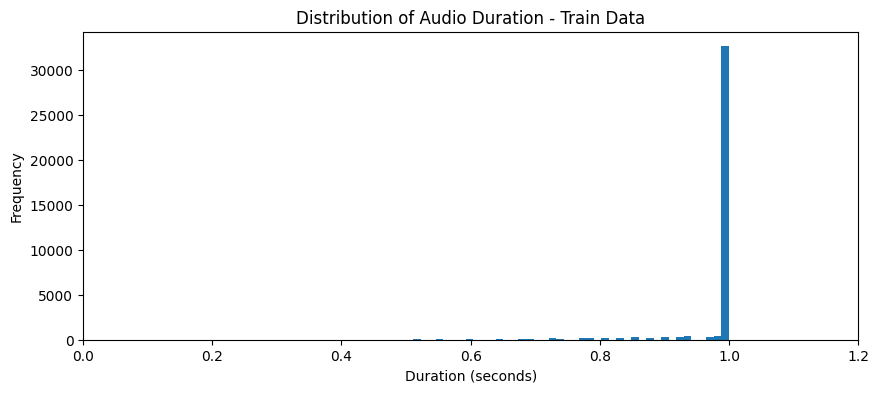

In [ ]:
# Plotting histogram of audio file durations in train data

plt.figure(figsize=(10,4))
plt.hist(X_train_duration, bins=50)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Duration - Train Data')
plt.xlim(0, 1.2)
plt.show()

In [ ]:
# Initialize lists to store raw audio samples and durations
X_test_raw_data = []
X_test_duration = []
for i in tqdm(range(len(X_test))):
    # apply load_wav function for each audio path file
    samples,duration = load_wav(X_test.values[i])
    # append raw audio sample in the form of array to the list
    X_test_raw_data.append(samples)
    # append duration of the audio to the list  
    X_test_duration.append(duration)

100%|██████████| 9061/9061 [00:15<00:00, 577.68it/s]


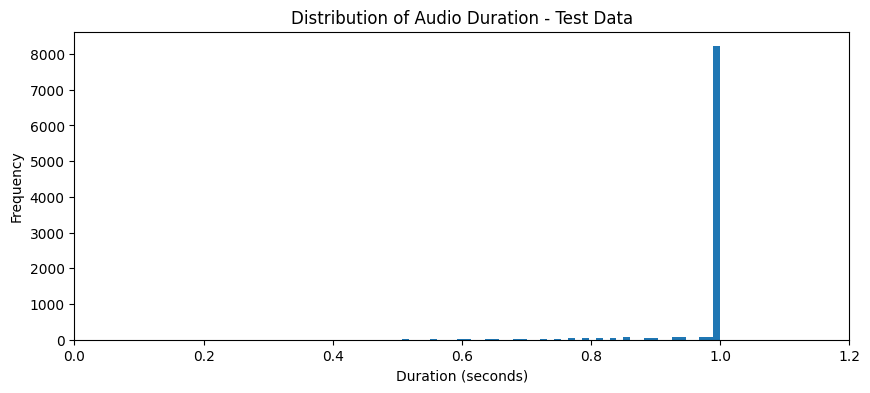

In [ ]:
# Plotting histogram of audio file durations in test data

plt.figure(figsize=(10,4))
plt.hist(X_test_duration, bins=50)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Duration - Test Data')
plt.xlim(0, 1.2)
plt.show()

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. Since all the files in train and test does not have exact duration of 1 sec, array lengths will not be same for all these files. Therefore we have to make all these arrays of same length of 22050 by padding.

In [ ]:
# Defining the maximum length for padding
max_length = 22050

In [ ]:
# Pad sequences in training data to ensure uniform length
X_train_pad_seq = pad_sequences(X_train_raw_data,maxlen=max_length,dtype='float32',
                                              padding='post')
# Pad sequences in test data to ensure uniform length
X_test_pad_seq  = pad_sequences(X_test_raw_data,maxlen=max_length,dtype='float32',
                                              padding='post')

In [ ]:
X_train_pad_seq.shape,X_test_pad_seq.shape

((36243, 22050), (9061, 22050))

We can now see the train and test has 22050 features

In [ ]:
def convert_to_spectrogram(raw_data):
    '''Convert raw audio data to a spectrogram using Mel spectrogram.'''
    
    # Compute Mel spectrogram
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=max_length, n_mels=64)
    # Convert power spectrogram to decibel (log) scale
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    # Return the resulting log Mel spectrogram
    return logmel_spectrum

In [ ]:
# Initialize lists to store spectrograms of training and test data
X_train_spectrogram = []
X_test_spectrogram  = []
for i in tqdm(X_train_pad_seq):
    # Convert the sequence to a spectrogram and append to the list
    X_train_spectrogram.append(convert_to_spectrogram(i))
for i in tqdm(X_test_pad_seq):
    # Convert the sequence to a spectrogram and append to the list
    X_test_spectrogram.append(convert_to_spectrogram(i))

100%|██████████| 9061/9061 [00:48<00:00, 186.67it/s]


In [ ]:
# Converting the lists to numpy arrays
X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram  = np.array(X_test_spectrogram)

In [ ]:
# Convert y_train_encoded to one-hot encoded categorical tensor
y_train_categorical = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_train_encoded,31))
# Convert y_test_encoded to one-hot encoded categorical tensor
y_test_categorical  = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_test_encoded,31))

In [ ]:
input_shape = (X_train_spectrogram.shape[1],X_train_spectrogram.shape[2],)

In [ ]:
# Initialize the weights using the He normal initializer with a seed value
initializer       = he_normal(seed=42)
# Define the input layer with the specified input shape
input_layer       = Input(shape = input_shape,dtype='float32')
# Define the LSTM layers with progressively decreasing units and return sequences for each layer
x        = LSTM(256,activation='tanh',return_sequences=True)(input_layer)
x        = LSTM(128,activation='tanh',return_sequences=True)(x)
x        = LSTM(64,activation='tanh',return_sequences=True)(x)

# Global average pooling to reduce the dimensionality
x        = GlobalAveragePooling1D()(x)

# Dense layers with ReLU activation and He normal initializer
x        = Dense(512, activation='relu', kernel_initializer=initializer)(x)
x        = Dense(256, activation='relu', kernel_initializer=initializer)(x)
x        = Dense(128, activation='relu', kernel_initializer=initializer)(x)
x        = Dense(64, activation='relu', kernel_initializer=initializer)(x)

# Batch normalization layer for stabilizing and accelerating the training process
x        = BatchNormalization()(x)

# Output layer with softmax activation for multi-class classification
output   = Dense(31, activation='softmax',kernel_initializer=initializer)(x)

# Create the model with input and output layers
model    = Model(inputs = input_layer,outputs = output,name='Speech_recognition_system')
# Compile the model with Adam optimizer, categorical crossentropy loss, and metrics
model.compile(optimizer =  Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',metrics=['categorical_accuracy'])
# Get the model summary
model.summary(line_length=120,show_trainable=True)

Model: "Speech_recognition_system"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 input_2 (InputLayer)                                 [(None, 64, 44)]                                0                 Y          
                                                                                                                                   
 lstm_2 (LSTM)                                        (None, 64, 256)                                 308224            Y          
                                                                                                                                   
 lstm_3 (LSTM)                                        (None, 64, 128)                                 197120            Y          
                                         

In [ ]:
# Early stopping callback to stop training if validation accuracy stops improving
early_stopping   = EarlyStopping(mode='max', monitor='val_categorical_accuracy',
                                 patience=4,verbose=1)
# Model checkpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/speech_recognition/custom_model.h5',
                                    mode='max', monitor='val_categorical_accuracy',
                                    save_best_only=True, verbose=1)
# Learning rate reduction callback to decrease learning rate if validation accuracy plateaus
learning_rate_callback = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.95,
                                           patience=2,mode='max',verbose=1)

In [ ]:
# fit the model with batch size of 16
model.fit(X_train_spectrogram,y_train_categorical,
          validation_data=(X_test_spectrogram,y_test_categorical),
          epochs=100,batch_size=16,
          callbacks = [early_stopping,model_checkpoint,learning_rate_callback],
          verbose = 1)

Epoch 1/100
2266/2266 [==============================] - ETA: 0s - loss: 3.0899 - categorical_accuracy: 0.1255
Epoch 1: val_categorical_accuracy improved from -inf to 0.14292, saving model to /content/drive/MyDrive/speech_recognition/custom_model.h5
2266/2266 [==============================] - 44s 16ms/step - loss: 3.0899 - categorical_accuracy: 0.1255 - val_loss: 2.9245 - val_categorical_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 2/100
2263/2266 [============================>.] - ETA: 0s - loss: 2.6319 - categorical_accuracy: 0.2294
Epoch 2: val_categorical_accuracy improved from 0.14292 to 0.23011, saving model to /content/drive/MyDrive/speech_recognition/custom_model.h5
2266/2266 [==============================] - 39s 17ms/step - loss: 2.6317 - categorical_accuracy: 0.2294 - val_loss: 2.6254 - val_categorical_accuracy: 0.2301 - lr: 1.0000e-04
Epoch 3/100
2264/2266 [============================>.] - ETA: 0s - loss: 2.2370 - categorical_accuracy: 0.3437
Epoch 3: val_categorical_accuracy 

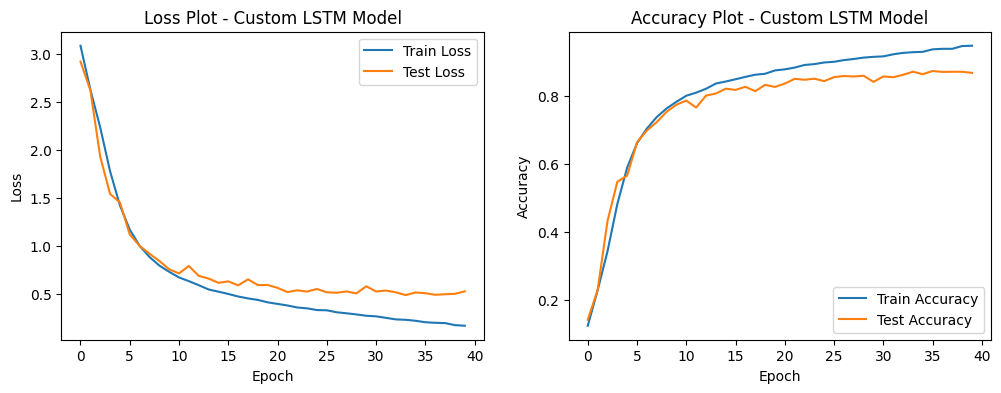

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot - Custom LSTM Model')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot - Custom LSTM Model')
plt.legend()

plt.show()

In [ ]:
# load the .h5 file
best_model = load_model('/content/drive/MyDrive/speech_recognition/custom_model.h5')

In [ ]:
with open('/content/drive/MyDrive/speech_recognition/labels.pkl', "wb") as file:
    pickle.dump(label_encoder.classes_, file)

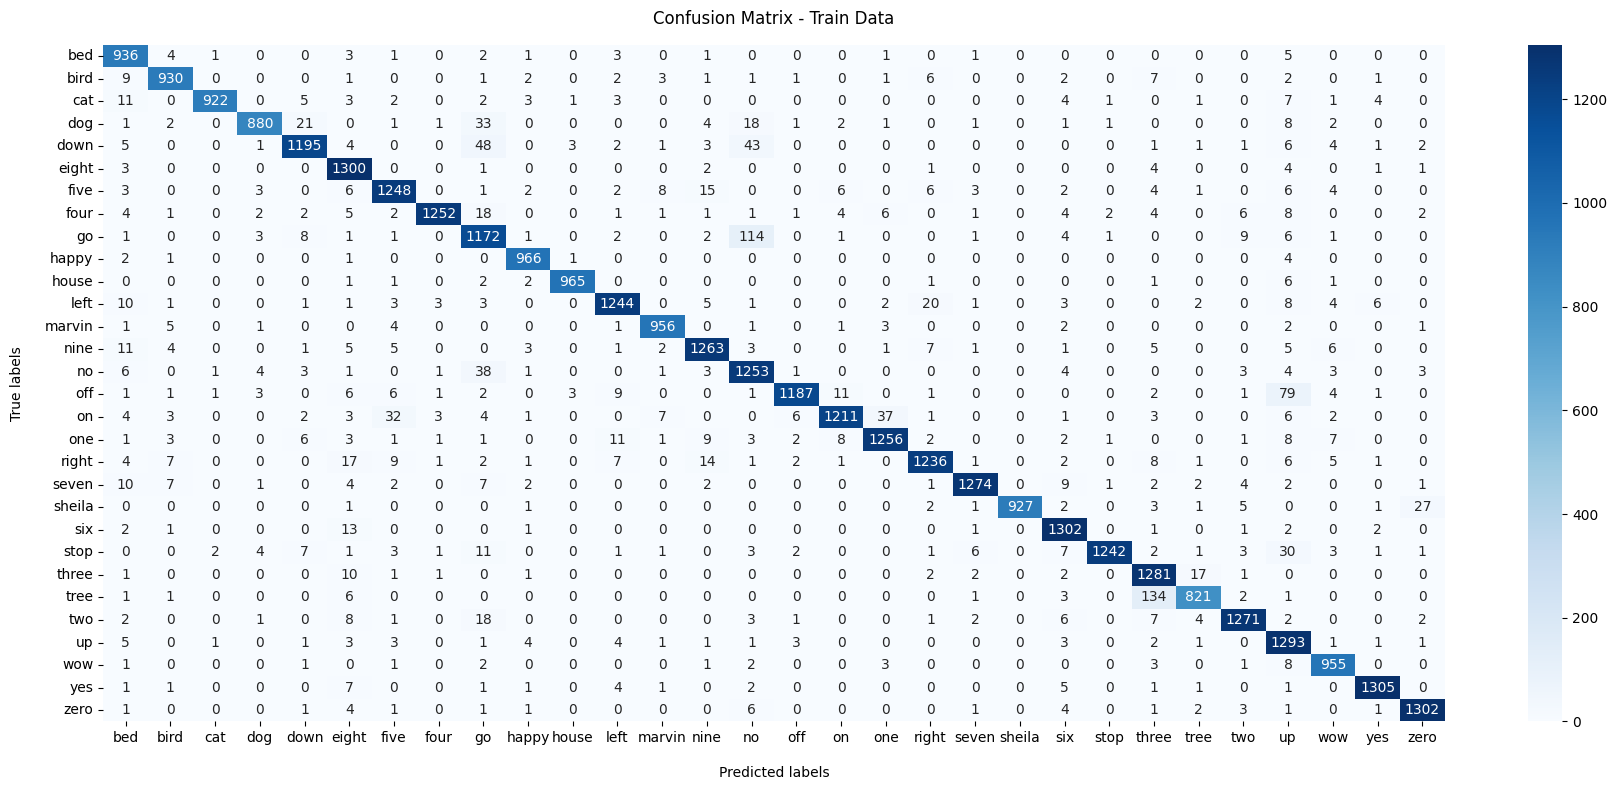

In [ ]:
# Plot confusion matrix for train data
cm_train = confusion_matrix(y_train_encoded,
                           np.argmax(best_model.predict(X_train_spectrogram,verbose=0),axis=1))
plt.figure(figsize=(18, 8))
sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels',labelpad=15)
plt.ylabel('True labels',labelpad=15)
plt.title('Confusion Matrix - Train Data',pad=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

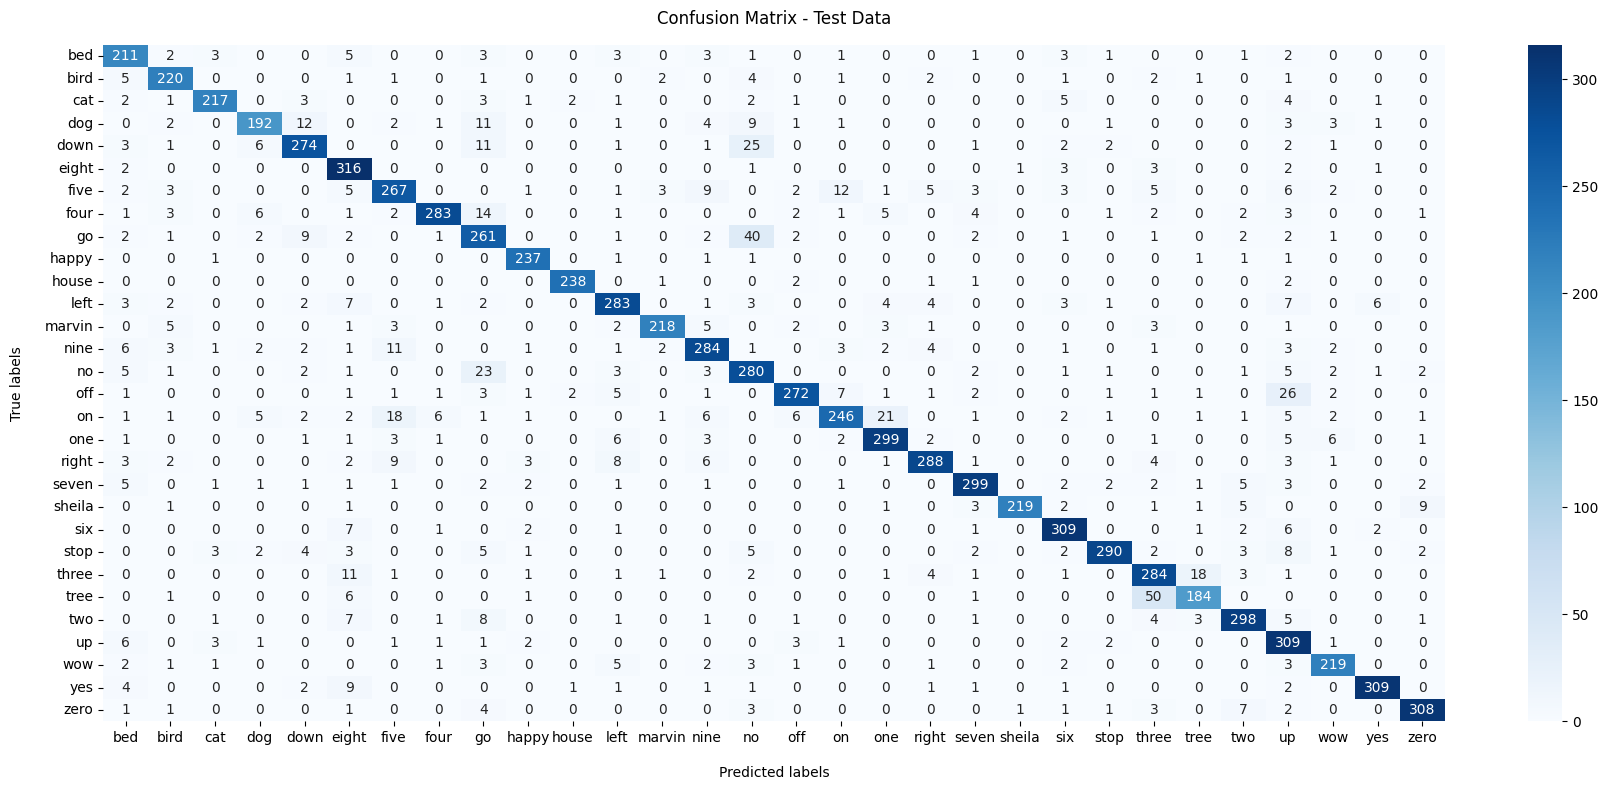

In [ ]:
# Plot confusion matrix for test data
cm_test = confusion_matrix(y_test_encoded,
                           np.argmax(best_model.predict(X_test_spectrogram,verbose=0),axis=1))
plt.figure(figsize=(18, 8))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels',labelpad=15)
plt.ylabel('True labels',labelpad=15)
plt.title('Confusion Matrix - Test Data',pad=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Predictions on sample test data**

In [ ]:
# Creating a random sample of 5 points from the test data
sample_test_data = test.sample(5)

In [ ]:
for i in range(5):
    x = sample_test_data['audio_path'].values[i]
    sample_rate, sample_data = wavfile.read(x)
    display(Audio(sample_data, rate=sample_rate))
    samples, _ = librosa.load(x, sr=22050)
    padded_sequence = pad_sequences([samples],maxlen=22050,dtype='float32',
                                              padding='post')
    spectrum = librosa.feature.melspectrogram(y=padded_sequence, sr=22050, n_mels=64)
    logmel_spectrum_data = librosa.power_to_db(S=spectrum, ref=np.max)
    prediction = np.argmax(best_model.predict(logmel_spectrum_data,verbose=0))
    predicted_label = label_encoder.classes_[prediction]
    print('Actual Label - ',sample_test_data['label'].values[i])
    print('Predicted Label - ',predicted_label)
    print('*'*100)

Actual Label -  eight
Predicted Label -  eight
****************************************************************************************************


Actual Label -  no
Predicted Label -  no
****************************************************************************************************


Actual Label -  happy
Predicted Label -  happy
****************************************************************************************************


Actual Label -  tree
Predicted Label -  tree
****************************************************************************************************


Actual Label -  left
Predicted Label -  left
****************************************************************************************************
